# Bike Sharing Demand — Classical Baselines + LSTM (Structured)
*Merged & cleaned on 2025-08-27 20:39:08*

본 노트북은 두 개의 원본을 통합하고, 중복 코드를 제거한 뒤 실행 순서에 맞게 재구성했습니다.

## Table of Contents
1. [Setup & Imports](#setup-imports)
2. [Utilities](#utilities)
3. [Data Loading](#data-loading)
4. [Feature Engineering](#feature-engineering)
5. [Windowing & Scaling](#windowing-scaling)
6. [Classical Baselines](#classical-baselines)
7. [LSTM Modeling](#lstm-modeling)
8. [Training & Evaluation](#training-evaluation)
9. [Residual Analysis](#residual-analysis)


## Setup & Imports  {#setup-imports}

## Utilities  {#utilities}
공통으로 사용하는 함수/클래스를 한 곳에 모았습니다.

## Data Loading  {#data-loading}

### 1. 데이터 준비 및 전처리
- `bike-sharing-demand/train.csv` 로드, `datetime` 파싱/정렬
- 시간 파생변수 생성(년/월/일/요일/시간)
- 시간 순서대로 train/val/test 분할


In [2]:
def load_hourly_data():
    path = '/Users/kimjinseok/Desktop/metacode-lecture/bike-sharing-demand/train.csv'
    if not os.path.exists(path):
        raise FileNotFoundError('train.csv 경로를 찾을 수 없습니다.')
    df = pd.read_csv(path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    cols = ['datetime','season','holiday','workingday','weather','temp','atemp','humidity','windspeed','casual','registered','count']
    return df[cols]


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['year'] = out['datetime'].dt.year
    out['month'] = out['datetime'].dt.month
    out['day'] = out['datetime'].dt.day
    out['dayofweek'] = out['datetime'].dt.dayofweek
    out['hour'] = out['datetime'].dt.hour
    return out


def split_by_time(df: pd.DataFrame, train_ratio: float = 0.8, val_ratio: float = 0.1):
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test


df = load_hourly_data()
print('데이터 크기:', df.shape, '기간:', df['datetime'].min(), '→', df['datetime'].max())
df_feat = add_time_features(df)
train_df, val_df, test_df = split_by_time(df_feat)


데이터 크기: (10886, 12) 기간: 2011-01-01 00:00:00 → 2012-12-19 23:00:00


### 1. 데이터 준비 및 전처리
- `bike-sharing-demand/train.csv` 로드, 시간 파생변수 생성
- train/val/test 시간 분할


In [55]:
def load_hourly_data():
    path = '/Users/kimjinseok/Desktop/metacode-lecture/bike-sharing-demand/train.csv'
    if not os.path.exists(path):
        raise FileNotFoundError('train.csv 경로를 찾을 수 없습니다.')
    df = pd.read_csv(path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    return df


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['year'] = out['datetime'].dt.year
    out['month'] = out['datetime'].dt.month
    out['day'] = out['datetime'].dt.day
    out['dayofweek'] = out['datetime'].dt.dayofweek
    out['hour'] = out['datetime'].dt.hour
    return out


def split_by_time(df: pd.DataFrame, train_ratio: float = 0.8, val_ratio: float = 0.1):
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test


def build_feature_matrix(df: pd.DataFrame):
    feature_cols = ['temp','atemp','humidity','windspeed','season','holiday','workingday','weather','year','month','dayofweek','hour']
    X = df[feature_cols].to_numpy(dtype=np.float32)
    y = df['count'].astype(np.float32).to_numpy()
    return X, y, feature_cols


df = load_hourly_data()
print('데이터 크기:', df.shape, '기간:', df['datetime'].min(), '→', df['datetime'].max())
df = add_time_features(df)
# 결측치 보간: 먼저 forward-fill, 남은 값은 back-fill
df = df.ffill().bfill()
train_df, val_df, test_df = split_by_time(df)


데이터 크기: (10886, 12) 기간: 2011-01-01 00:00:00 → 2012-12-19 23:00:00


## Feature Engineering  {#feature-engineering}

In [ ]:
def to_supervised_features(df: pd.DataFrame, target: str = 'count'):
    feature_cols = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','year','month','day','dayofweek','hour']
    X = df[feature_cols].copy()
    X = pd.get_dummies(X, columns=['season','holiday','workingday','weather','year','month','dayofweek','hour'], drop_first=False)
    y = df[target].astype(float)
    return X, y


def compute_metrics(y_true, y_pred):
    mae = float(mean_absolute_error(y_true, y_pred))
    mse = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))

    var_y = float(np.var(y_true))
    if var_y < 1e-12:
        r2 = 1.0 if mse < 1e-12 else 0.0
    else:
        r2 = float(1.0 - mse / var_y)

    print("[Metrics]")
    print(f"MAE  : {mae:.6f} - 평균 절대 오차")
    print(f"MSE  : {mse:.6f} - 평균 제곱 오차")
    print(f"RMSE : {rmse:.6f} - 제곱근 평균 제곱 오차")
    print(f"R^2  : {r2:.6f} - 결정계수(설명된 분산 비율)")

    return mae, mse, rmse, r2


def plot_actual_vs_pred(dt_index, y_true, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(dt_index, y_true, label='Actual')
    plt.plot(dt_index, y_pred, label='Pred')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()


# 분할별 특징 생성
X_train, y_train = to_supervised_features(train_df)
X_val, y_val     = to_supervised_features(val_df)
X_test, y_test   = to_supervised_features(test_df)

# 학습 컬럼에 맞춰 정렬/보정 (없는 컬럼은 0 채움)
X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

[Metrics]
MAE  : 112.461157 - 평균 절대 오차
MSE  : 21701.572466 - 평균 제곱 오차
RMSE : 147.314536 - 제곱근 평균 제곱 오차
R^2  : 0.611101 - 결정계수(설명된 분산 비율)
Linear/VAL (112.46115659982183, 21701.5724664791, 147.3145358288825, 0.6111009463256456)
[Metrics]
MAE  : 84.412417 - 평균 절대 오차
MSE  : 12720.204474 - 평균 제곱 오차
RMSE : 112.783884 - 제곱근 평균 제곱 오차
R^2  : 0.662295 - 결정계수(설명된 분산 비율)
Linear/TEST (84.41241701047062, 12720.204474477732, 112.78388393062961, 0.6622946885094285)


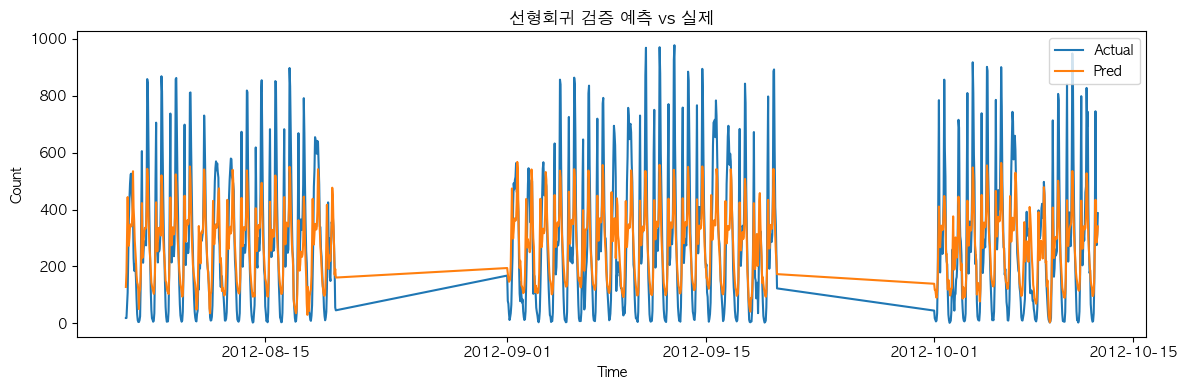

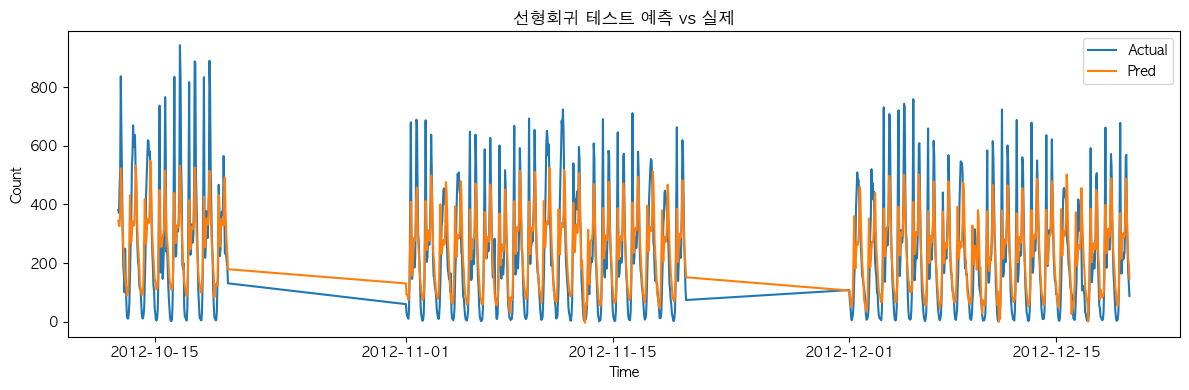

[Metrics]
MAE  : 59.311357 - 평균 절대 오차
MSE  : 8326.449294 - 평균 제곱 오차
RMSE : 91.249380 - 제곱근 평균 제곱 오차
R^2  : 0.850787 - 결정계수(설명된 분산 비율)
RF/VAL (59.31135723039216, 8326.449294475082, 91.2493796936455, 0.8507873908173891)
[Metrics]
MAE  : 68.762976 - 평균 절대 오차
MSE  : 10117.330518 - 평균 제곱 오차
RMSE : 100.584942 - 제곱근 평균 제곱 오차
R^2  : 0.731398 - 결정계수(설명된 분산 비율)
RF/TEST (68.76297553516821, 10117.330518318044, 100.58494180700232, 0.7313976940388812)


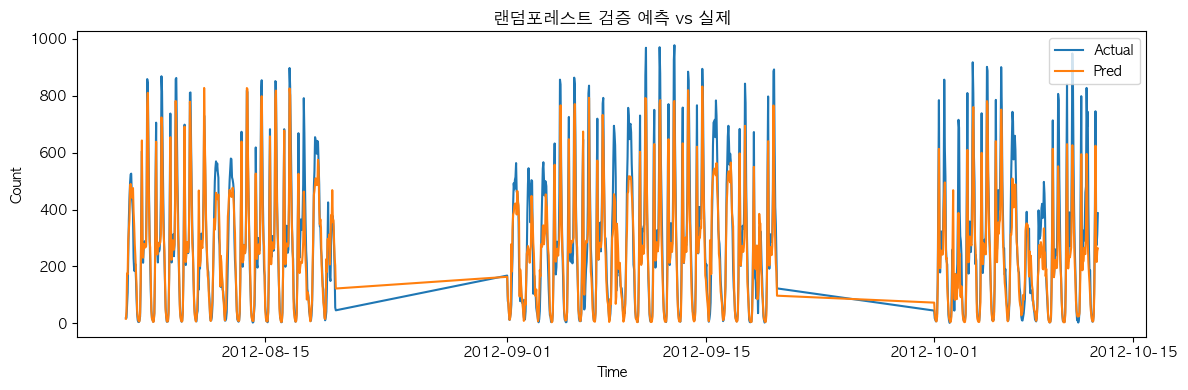

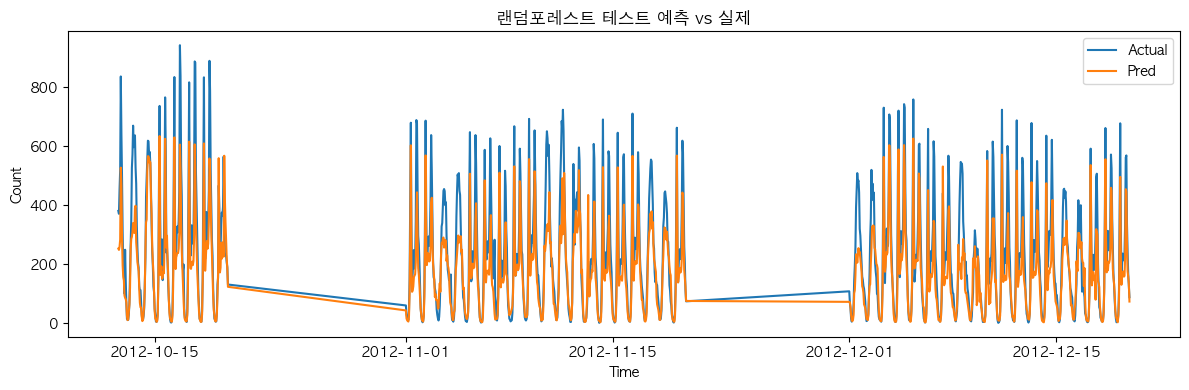

RF 중요도 TOP 15:
 atemp           0.186645
hour_17         0.094062
humidity        0.084904
hour_18         0.079720
hour_8          0.055163
workingday_0    0.047907
workingday_1    0.047481
temp            0.041277
year_2011       0.030997
year_2012       0.030407
hour_19         0.030261
hour_7          0.016440
hour_2          0.015388
hour_1          0.015234
day             0.014464
dtype: float64


In [4]:


from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(X_train, y_train)
lin_val_pred  = lin.predict(X_val)
lin_test_pred = lin.predict(X_test)

print('Linear/VAL', compute_metrics(y_val.to_numpy(), lin_val_pred))
print('Linear/TEST', compute_metrics(y_test.to_numpy(), lin_test_pred))
plot_actual_vs_pred(val_df['datetime'].values, y_val.to_numpy(), lin_val_pred, '선형회귀 검증 예측 vs 실제')
plot_actual_vs_pred(test_df['datetime'].values, y_test.to_numpy(), lin_test_pred, '선형회귀 테스트 예측 vs 실제')

rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
rf_val_pred = rf.predict(X_val)
rf_test_pred = rf.predict(X_test)
print('RF/VAL', compute_metrics(y_val.to_numpy(), rf_val_pred))
print('RF/TEST', compute_metrics(y_test.to_numpy(), rf_test_pred))
plot_actual_vs_pred(val_df['datetime'].values, y_val.to_numpy(), rf_val_pred, '랜덤포레스트 검증 예측 vs 실제')
plot_actual_vs_pred(test_df['datetime'].values, y_test.to_numpy(), rf_test_pred, '랜덤포레스트 테스트 예측 vs 실제')

try:
    importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print('RF 중요도 TOP 15:\n', importances.head(15))
except Exception:
    pass


In [5]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 0) 전체 피처/타깃 생성
X_all_ts, y_all_ts = to_supervised_features(df_feat)

# (선택) 시간 인덱스 정렬이 필요하면 사용
# X_all_ts = X_all_ts.sort_index()
# y_all_ts = y_all_ts.loc[X_all_ts.index]

# 1) 홀드아웃 분할: 마지막 20%를 최종 테스트로 보존
split_idx = int(len(X_all_ts) * 0.8)
X_cv_ts,  y_cv_ts   = X_all_ts.iloc[:split_idx], y_all_ts.iloc[:split_idx]   # ← 교차검증(튜닝) 구간
X_test_ts, y_test_ts = X_all_ts.iloc[split_idx:], y_all_ts.iloc[split_idx:]  # ← 최종 테스트 구간 (시계열 테스트셋)

print(f"[SHAPE] X_cv_ts={X_cv_ts.shape}, y_cv_ts={y_cv_ts.shape}, "
      f"X_test_ts={X_test_ts.shape}, y_test_ts={y_test_ts.shape}")

# 2) 시계열 교차검증 분할기 (CV 전용)
tscv_cv = TimeSeriesSplit(n_splits=5)

# 3) 하이퍼파라미터 그리드 & 모델/서치 객체 (CV 전용)
param_grid_rf = {"n_estimators": [200, 300], "max_depth": [None, 12, 24]}
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_gs_cv = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=tscv_cv,
    scoring='neg_root_mean_squared_error',  # RMSE의 음수
    n_jobs=-1
)

# 4) CV 구간으로 그리드서치 실행
rf_gs_cv.fit(X_cv_ts, y_cv_ts)

print('최적 하이퍼파라미터(CV):', rf_gs_cv.best_params_)
print('CV RMSE:', -rf_gs_cv.best_score_)

# 5) 최적 모델을 CV 구간 전체로 재학습 (재적합)
rf_best_cv_ts = rf_gs_cv.best_estimator_
rf_best_cv_ts.fit(X_cv_ts, y_cv_ts)

# 6) 최종 시계열 테스트 평가
y_pred_test_ts = rf_best_cv_ts.predict(X_test_ts)

mae_ts = mean_absolute_error(y_test_ts, y_pred_test_ts)
mse_ts = mean_squared_error(y_test_ts, y_pred_test_ts)
rmse_ts = np.sqrt(mse_ts)
r2_ts = r2_score(y_test_ts, y_pred_test_ts)

print("\n[TEST Metrics - Time Series Holdout]")
print(f"MAE  : {mae_ts:.3f}")
print(f"MSE  : {mse_ts:.3f}")
print(f"RMSE : {rmse_ts:.3f}")
print(f"R^2  : {r2_ts:.3f}")



[SHAPE] X_cv_ts=(8708, 62), y_cv_ts=(8708,), X_test_ts=(2178, 62), y_test_ts=(2178,)
최적 하이퍼파라미터(CV): {'max_depth': None, 'n_estimators': 200}
CV RMSE: 93.78490562597392

[TEST Metrics - Time Series Holdout]
MAE  : 63.831
MSE  : 9158.992
RMSE : 95.703
R^2  : 0.807


In [ ]:
def train_model(model, train_loader, val_loader, epochs: int, lr: float, device):
    criterion = nn.MSELoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=3)
    patience = 8
    no_improve = 0
    best_val = float('inf')
    best_state = None
    for ep in range(1, epochs+1):
        model.train()
        tr_sum, n = 0.0, 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optim.step()
            tr_sum += float(loss.item()) * len(xb)
            n += len(xb)
        tr_loss = tr_sum / max(n, 1)

        model.eval()
        with torch.no_grad():
            va_sum, n2 = 0.0, 0
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                va_sum += float(loss.item()) * len(xb)
                n2 += len(xb)
        va_loss = va_sum / max(n2, 1)
        print(f'Epoch {ep:03d} - train MSE: {tr_loss:.4f}, val MSE: {va_loss:.4f}')
        scheduler.step(va_loss)
        if va_loss + 1e-9 < best_val:
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f'[EarlyStop] epoch={ep} val={va_loss:.5f}')
                break
        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    if best_state is not None:
        model.load_state_dict(best_state)


def predict_all(model, loader, device):
    model.eval()
    outs = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            pred = model(xb)
            outs.append(pred.cpu().numpy())
    return np.concatenate(outs, axis=0)


def plot_series(dt_index, y_true, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(dt_index, y_true, label='Actual')
    plt.plot(dt_index, y_pred, label='Pred')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()


# 데이터 구성 및 학습
# 3가지 개선 적용: 주간 창(168), 시간 원형 인코딩, 로그 타깃

def add_cyclical_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['hour_sin'] = np.sin(2*np.pi*out['hour']/24)
    out['hour_cos'] = np.cos(2*np.pi*out['hour']/24)
    return out

train_df = add_cyclical_cols(train_df)
val_df   = add_cyclical_cols(val_df)
test_df  = add_cyclical_cols(test_df)

X_train, y_train, feat_cols = build_feature_matrix(train_df)
X_val,   y_val,   _         = build_feature_matrix(val_df)
X_test,  y_test,  _         = build_feature_matrix(test_df)

# 시간 원형 인코딩을 X에 추가(기존 함수는 수정하지 않고 배열에 이어붙임)
def append_cols(X: np.ndarray, df: pd.DataFrame, cols: list[str]) -> np.ndarray:
    return np.concatenate([X, df[cols].to_numpy(dtype=np.float32)], axis=1)

X_train = append_cols(X_train, train_df, ['hour_sin','hour_cos'])
X_val   = append_cols(X_val,   val_df,   ['hour_sin','hour_cos'])
X_test  = append_cols(X_test,  test_df,  ['hour_sin','hour_cos'])

# 표준화 (train 기준)
mean = X_train.mean(axis=0, keepdims=True)
std  = X_train.std(axis=0, keepdims=True) + 1e-8
X_train = (X_train - mean) / std
X_val   = (X_val   - mean) / std
X_test  = (X_test  - mean) / std

# 로그 타깃 적용
use_log_target = True
if use_log_target:
    y_train = np.log1p(y_train)
    y_val   = np.log1p(y_val)
    y_test  = np.log1p(y_test)

# 주간 패턴을 학습하도록 창 크기 확대
window = 168
Xtr_seq, ytr_seq = make_windows(X_train, y_train, window)
Xva_seq, yva_seq = make_windows(X_val,   y_val,   window)
Xte_seq, yte_seq = make_windows(X_test,  y_test,  window)

# A방법: 클래스 없이 리스트 기반 데이터셋으로 구성
# 1) y의 마지막 차원 제거(필요시)
ytr_1d = ytr_seq.squeeze(-1) if ytr_seq.ndim > 1 else ytr_seq
yva_1d = yva_seq.squeeze(-1) if yva_seq.ndim > 1 else yva_seq
yte_1d = yte_seq.squeeze(-1) if yte_seq.ndim > 1 else yte_seq

# 2) 텐서 변환
a2_Xtr = torch.as_tensor(Xtr_seq, dtype=torch.float32)
a2_ytr = torch.as_tensor(ytr_1d,  dtype=torch.float32)
a2_Xva = torch.as_tensor(Xva_seq, dtype=torch.float32)
a2_yva = torch.as_tensor(yva_1d,  dtype=torch.float32)
a2_Xte = torch.as_tensor(Xte_seq, dtype=torch.float32)
a2_yte = torch.as_tensor(yte_1d,  dtype=torch.float32)

# 3) (x, y) 튜플 리스트로 묶기
train_data = list(zip(a2_Xtr, a2_ytr))
val_data   = list(zip(a2_Xva, a2_yva))
test_data  = list(zip(a2_Xte, a2_yte))

# 4) DataLoader 구성 (drop_last는 DataLoader 인자)
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, drop_last=True)
val_loader   = DataLoader(val_data,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=256, shuffle=False)

_set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 클래스 없이 nn.LSTM + nn.Linear로 학습/예측
input_size = Xtr_seq.shape[-1]
lstm_nc, head_nc, _ = make_lstm_pair(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.1, device=device)

params_nc = list(lstm_nc.parameters()) + list(head_nc.parameters())
optim_nc = torch.optim.Adam(params_nc, lr=1e-3)
crit_nc = nn.MSELoss()
scheduler_nc = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_nc, factor=0.5, patience=3)

best_val = float('inf')
best_state = None
patience = 8
no_improve = 0

for ep in range(1, 21):
    lstm_nc.train(); head_nc.train()
    tr_sum, n = 0.0, 0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        pred = lstm_forward(lstm_nc, head_nc, xb)
        loss = crit_nc(pred, yb)
        optim_nc.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params_nc, max_norm=1.0)
        optim_nc.step()
        tr_sum += float(loss.item()) * len(xb)
        n += len(xb)
    tr_loss = tr_sum / max(n, 1)

    lstm_nc.eval(); head_nc.eval()
    with torch.no_grad():
        va_sum, n2 = 0.0, 0
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = lstm_forward(lstm_nc, head_nc, xb)
            loss = crit_nc(pred, yb)
            va_sum += float(loss.item()) * len(xb)
            n2 += len(xb)
    va_loss = va_sum / max(n2, 1)
    print(f'Epoch {ep:03d} - train MSE: {tr_loss:.4f}, val MSE: {va_loss:.4f}')
    scheduler_nc.step(va_loss)
    if va_loss + 1e-9 < best_val:
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f'[EarlyStop] epoch={ep} val={va_loss:.5f}')
            break
    if va_loss < best_val:
        best_val = va_loss
        best_state = {
            'lstm': {k: v.detach().cpu().clone() for k, v in lstm_nc.state_dict().items()},
            'head': {k: v.detach().cpu().clone() for k, v in head_nc.state_dict().items()},
        }

if best_state is not None:
    lstm_nc.load_state_dict(best_state['lstm'])
    head_nc.load_state_dict(best_state['head'])

# 예측
with torch.no_grad():
    lstm_nc.eval(); head_nc.eval()
    outs_v = []
    for xb, _ in val_loader:
        xb = xb.to(device)
        pred = lstm_forward(lstm_nc, head_nc, xb)
        outs_v.append(pred.cpu().numpy())
    val_pred = np.concatenate(outs_v, axis=0)

with torch.no_grad():
    lstm_nc.eval(); head_nc.eval()
    outs_t = []
    for xb, _ in test_loader:
        xb = xb.to(device)
        pred = lstm_forward(lstm_nc, head_nc, xb)
        outs_t.append(pred.cpu().numpy())
    test_pred = np.concatenate(outs_t, axis=0)

val_idx = val_df['datetime'].iloc[window:].values
test_idx = test_df['datetime'].iloc[window:].values

# 플롯도 로그 복원 후 표시
if 'use_log_target' in globals() and use_log_target:
    plot_series(val_idx, np.expm1(yva_seq.squeeze(-1)), np.expm1(val_pred), 'LSTM 검증 예측 vs 실제')
    plot_series(test_idx, np.expm1(yte_seq.squeeze(-1)), np.expm1(test_pred), 'LSTM 테스트 예측 vs 실제')
else:
    plot_series(val_idx, yva_seq.squeeze(-1), val_pred, 'LSTM 검증 예측 vs 실제')
    plot_series(test_idx, yte_seq.squeeze(-1), test_pred, 'LSTM 테스트 예측 vs 실제')


## Windowing & Scaling  {#windowing-scaling}

In [1]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    from prophet import Prophet
    _HAS_PROPHET = True
except Exception:
    _HAS_PROPHET = False

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=r"Glyph.*missing from font.*", category=UserWarning)

# 한글 폰트 설정 및 마이너스 기호 깨짐 방지 (후보군을 sans-serif 우선순위로 지정)
def _set_korean_font() -> None:
    font_candidates = [
        "AppleGothic",
        "NanumGothic",
        "Malgun Gothic",
        "Noto Sans CJK KR",
        "Noto Sans KR",
        "DejaVu Sans",
    ]
    # 우선순위 리스트를 그대로 등록하여 사용 가능한 항목으로 대체되도록 함
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = font_candidates
    plt.rcParams["axes.unicode_minus"] = False

_set_korean_font()

pd.set_option('display.max_columns', 100)


/Users/kimjinseok/Desktop/metacode-lecture/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 잔차 분석 결과 (Random Forest)

### 1. 잔차 시계열 (Residual Time Series)
- 시간 축에 따라 예측 오차(실제값 - 예측값)를 표시한 그래프  
- **특징**:
  - 대부분 잔차가 0 근처에 분포하지만, 구간별로 뭉침 현상이 보임
  - 일부 시점에서 큰 양수(과소예측) 또는 음수(과대예측) 피크 발생
  - 완전히 무작위(white noise) 형태가 아니며, 시간에 따른 구조적 패턴이 남아 있음  

👉 **해석**:  
모델이 평균적으로는 잘 맞추지만, **특정 시점(급등/급락 구간 등)**에서는 예측력이 떨어지며,  
이는 모델이 **계절성/추세 같은 일부 패턴을 충분히 반영하지 못했음을 시사**함.

---

### 2. 잔차 분포 (Residual Histogram)
- 잔차 값의 빈도 분포를 나타낸 그래프  
- **특징**:
  - 중심이 0 근처에 있으며, 대체로 좌우 대칭에 가까운 형태
  - 다만 오른쪽 꼬리(양의 잔차)가 조금 더 길어 실제보다 작게 예측하는 경향이 일부 존재
  - 대부분 잔차는 -100 ~ +200 구간에 분포, 소수의 극단값(±200~400) 존재  

👉 **해석**:  
잔차 분포는 대체로 정규분포에 가까워 **큰 편향은 없지만**,  
약간의 오른쪽 비대칭성으로 인해 **과소예측 경향**이 확인됨.  
또한 일부 **이상치(Outlier)** 오차가 존재하여 개선 여지가 있음.

---

### 🔎 종합 결론
- RF(RandomForest) 모델은 전반적으로 성능이 양호하나,  
  1. 잔차 시계열에서 **시간 구조적 패턴**이 남아 있음  
  2. 잔차 분포에서 **과소예측 경향 및 이상치**가 확인됨  

👉 **개선 방향**:
- 시계열 특성을 반영한 피처 추가 (요일, 주기성, Lag, Rolling Mean 등)
- 다른 알고리즘(XGBoost, LightGBM, LSTM 등) 비교 적용
- 잔차 기반 추가 피처 엔지니어링 진행


[Metrics]
MAE  : 36.915106 - 평균 절대 오차
MSE  : 2645.839036 - 평균 제곱 오차
RMSE : 51.437720 - 제곱근 평균 제곱 오차
R^2  : -0.276301 - 결정계수(설명된 분산 비율)
SARIMA/VAL (36.915105848758586, 2645.8390363580256, 51.43771997627836, -0.2763014988133232)
[Metrics]
MAE  : 49.686400 - 평균 절대 오차
MSE  : 3041.212785 - 평균 제곱 오차
RMSE : 55.147192 - 제곱근 평균 제곱 오차
R^2  : -1.677988 - 결정계수(설명된 분산 비율)
SARIMA/TEST (49.686400457179325, 3041.212784723112, 55.147191993093465, -1.677987591640588)


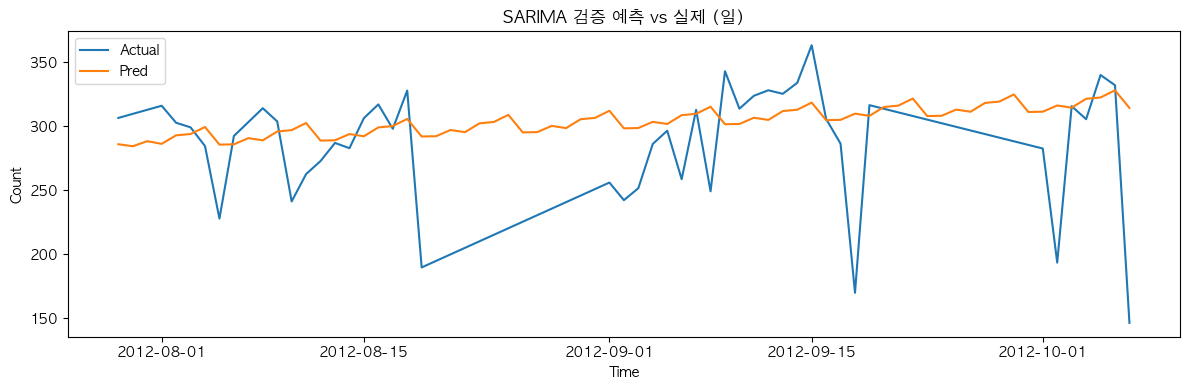

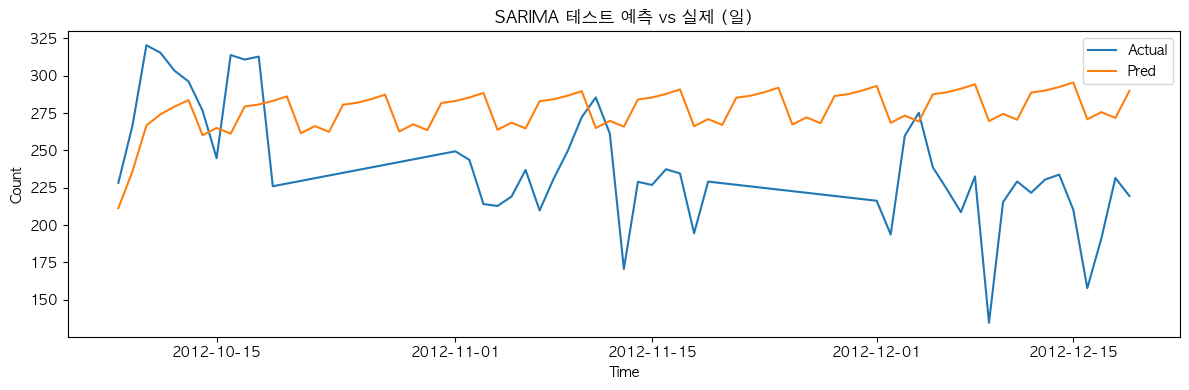

23:35:14 - cmdstanpy - INFO - Chain [1] start processing
23:35:14 - cmdstanpy - INFO - Chain [1] done processing


[Metrics]
MAE  : 55.136594 - 평균 절대 오차
MSE  : 5054.311634 - 평균 제곱 오차
RMSE : 71.093682 - 제곱근 평균 제곱 오차
R^2  : -1.438102 - 결정계수(설명된 분산 비율)
Prophet/VAL (55.136593561391784, 5054.311634076586, 71.09368209676994, -1.4381020256323187)


In [10]:
def aggregate_daily(df: pd.DataFrame) -> pd.Series:
    return df.set_index('datetime')['count'].resample('D').mean()


daily = aggregate_daily(df)
daily = daily.asfreq('D').interpolate().ffill().bfill()
N = len(daily)
N_tr, N_va = int(N*0.8), int(N*0.1)
daily_tr = daily.iloc[:N_tr]
daily_va = daily.iloc[N_tr:N_tr+N_va]
daily_te = daily.iloc[N_tr+N_va:]

sar = SARIMAX(daily_tr, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
va_fc = sar.forecast(steps=len(daily_va)).to_numpy()
combined = pd.concat([daily_tr, daily_va])
#te_fc = SARIMAX(daily_tr.append(daily_va), order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False).forecast(steps=len(daily_te)).to_numpy()
te_fc = (
    SARIMAX(combined, order=(1,1,1), seasonal_order=(1,1,1,7),
            enforce_stationarity=False, enforce_invertibility=False)
    .fit(disp=False)
    .forecast(steps=len(daily_te))
    .to_numpy()
)
print('SARIMA/VAL', compute_metrics(daily_va.to_numpy(), va_fc))
print('SARIMA/TEST', compute_metrics(daily_te.to_numpy(), te_fc))
plot_actual_vs_pred(daily_va.index, daily_va.to_numpy(), va_fc, 'SARIMA 검증 예측 vs 실제 (일)')
plot_actual_vs_pred(daily_te.index, daily_te.to_numpy(), te_fc, 'SARIMA 테스트 예측 vs 실제 (일)')

if _HAS_PROPHET:
    dprop = pd.DataFrame({'ds': daily_tr.index, 'y': daily_tr.values})
    m = Prophet(seasonality_mode='additive', weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=False)
    m.fit(dprop)
    future = pd.DataFrame({'ds': pd.date_range(start=daily_tr.index[-1] + pd.Timedelta(days=1), periods=len(daily_va), freq='D')})
    yhat_val = m.predict(future)['yhat'].to_numpy()
    print('Prophet/VAL', compute_metrics(daily_va.to_numpy(), yhat_val))
else:
    print('Prophet 미설치: 건너뜀')


In [56]:
def make_windows(X: np.ndarray, y: np.ndarray, window: int, horizon: int = 1):
    xs, ys = [], []
    for i in range(len(X) - window - horizon + 1):
        xs.append(X[i:i+window])
        ys.append(y[i+window:i+window+horizon])
    return np.asarray(xs, dtype=np.float32), np.asarray(ys, dtype=np.float32)


### 3. 학습/검증/테스트
- 표준화: train 기준 평균/표준편차
- 학습: Adam + MSE, 베스트 모델 선택
- 예측 vs 실제 시각화


LSTM/VAL (50.116783142089844, 5978.74169921875, 77.32232342098077, 26.463699340820312, 0.8608695652173913)
LSTM/TEST (46.46815872192383, 4709.2314453125, 68.62384021105566, 29.130691289901733, 0.8026030368763557)


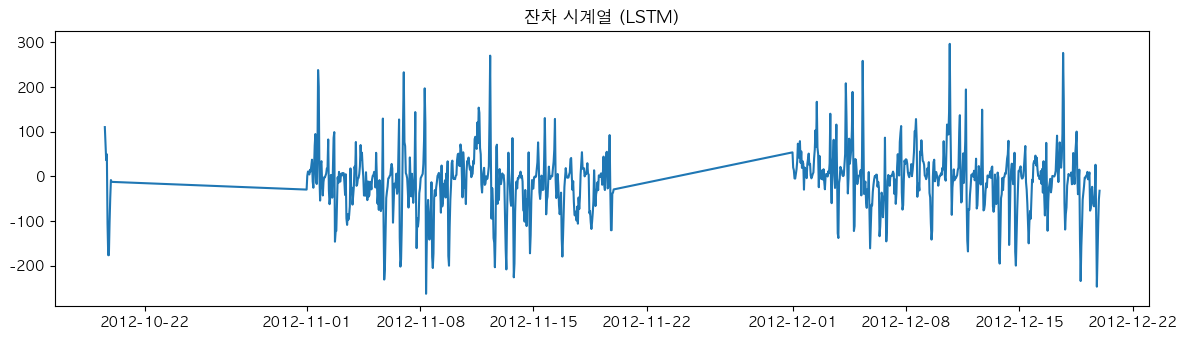

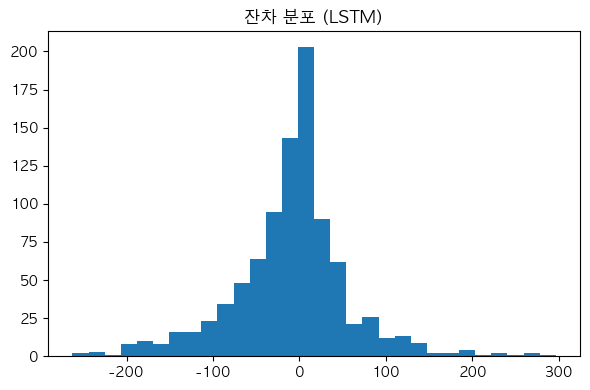

In [ ]:
def compute_metrics(y_true, y_pred):
    mae = float(np.mean(np.abs(y_true - y_pred)))
    mse = float(np.mean((y_true - y_pred)**2))
    rmse = float(np.sqrt(mse))
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100.0)
    prev = np.concatenate([[y_true[0]], y_true[:-1]])
    da = float(np.mean((np.sign(y_true - prev) == np.sign(y_pred - prev)).astype(float)))
    return mae, mse, rmse, mape, da

# 로그 타깃 복원 후 평가
if 'use_log_target' in globals() and use_log_target:
    yva_true = np.expm1(yva_seq.squeeze(-1))
    yte_true = np.expm1(yte_seq.squeeze(-1))
    val_pred_eval = np.expm1(val_pred)
    test_pred_eval = np.expm1(test_pred)
else:
    yva_true = yva_seq.squeeze(-1)
    yte_true = yte_seq.squeeze(-1)
    val_pred_eval = val_pred
    test_pred_eval = test_pred

print('LSTM/VAL', compute_metrics(yva_true, val_pred_eval))
print('LSTM/TEST', compute_metrics(yte_true, test_pred_eval))

# 잔차 분석(복원된 스케일 기준)
residual = yte_true - test_pred_eval
plt.figure(figsize=(12,3.5))
plt.plot(test_idx, residual)
plt.title('잔차 시계열 (LSTM)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(residual, bins=30)
plt.title('잔차 분포 (LSTM)')
plt.tight_layout(); plt.show()


In [ ]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 준비: 윈도우 데이터(X*_seq, y*_seq)와 표준화 통계(mean, std)는 기존 셀에서 생성됨
# Xtr_seq:[N,T,F], ytr_seq:[N] (또는 [N,1]) 가정

def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# 디바이스 선택(MPS 비활성 시 CPU)
_device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# 텐서 변환 및 데이터로더 구성
_Xtr = to_tensor(Xtr_seq).to(_device)
_ytr = to_tensor(ytr_seq.squeeze(-1) if ytr_seq.ndim > 1 else ytr_seq).to(_device)
_Xva = to_tensor(Xva_seq).to(_device)
_yva = to_tensor(yva_seq.squeeze(-1) if yva_seq.ndim > 1 else yva_seq).to(_device)
_Xte = to_tensor(Xte_seq).to(_device)
_yte = to_tensor(yte_seq.squeeze(-1) if yte_seq.ndim > 1 else yte_seq).to(_device)

train_ds2 = TensorDataset(_Xtr, _ytr)
val_ds2   = TensorDataset(_Xva, _yva)
test_ds2  = TensorDataset(_Xte, _yte)

train_dl2 = DataLoader(train_ds2, batch_size=128, shuffle=False, drop_last=True)
val_dl2   = DataLoader(val_ds2,   batch_size=256, shuffle=False)
test_dl2  = DataLoader(test_ds2,  batch_size=256, shuffle=False)

# 모델 인스턴스(클래스 정의 없이)
input_size = _Xtr.shape[-1]
hidden_size = 64
num_layers = 1

lstm2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True).to(_device)
head2 = nn.Linear(hidden_size, 1).to(_device)

params2 = list(lstm2.parameters()) + list(head2.parameters())
optim2 = torch.optim.Adam(params2, lr=1e-3)
crit2 = nn.MSELoss()

# 순전파 함수

def forward_step2(x_batch: torch.Tensor) -> torch.Tensor:
    out, _ = lstm2(x_batch)
    last = out[:, -1, :]
    pred = head2(last).squeeze(-1)
    return pred

# 학습 루프

def train_epoch2(loader: DataLoader) -> float:
    lstm2.train(); head2.train()
    total, n = 0.0, 0
    for xb, yb in loader:
        optim2.zero_grad(set_to_none=True)
        pred = forward_step2(xb)
        loss = crit2(pred, yb)
        loss.backward()
        optim2.step()
        total += float(loss.item()) * yb.size(0)
        n += yb.size(0)
    return total / max(n, 1)

@torch.no_grad()
def eval_mse2(loader: DataLoader) -> float:
    lstm2.eval(); head2.eval()
    total, n = 0.0, 0
    for xb, yb in loader:
        pred = forward_step2(xb)
        loss = crit2(pred, yb)
        total += float(loss.item()) * yb.size(0)
        n += yb.size(0)
    return total / max(n, 1)

best_state2 = None
best_val2 = float('inf')
for ep in range(1, 11):
    tr = train_epoch2(train_dl2)
    va = eval_mse2(val_dl2)
    print(f'[NoClass] Epoch {ep:02d} | train MSE {tr:.4f} | val MSE {va:.4f}')
    if va < best_val2:
        best_val2 = va
        best_state2 = {
            'lstm': {k: v.detach().cpu().clone() for k, v in lstm2.state_dict().items()},
            'head': {k: v.detach().cpu().clone() for k, v in head2.state_dict().items()},
        }

# 베스트 로드
if best_state2 is not None:
    lstm2.load_state_dict(best_state2['lstm'])
    head2.load_state_dict(best_state2['head'])

# 예측
@torch.no_grad()
def predict_all2(loader: DataLoader) -> np.ndarray:
    lstm2.eval(); head2.eval()
    outs = []
    for xb, _ in loader:
        pred = forward_step2(xb)
        outs.append(pred.cpu().numpy())
    return np.concatenate(outs, axis=0)

val_pred2 = predict_all2(val_dl2)
test_pred2 = predict_all2(test_dl2)

# 간단한 성능 확인
from math import sqrt
mae2 = float(np.mean(np.abs((_yva.cpu().numpy()) - val_pred2)))
rmse2 = sqrt(float(np.mean(((_yva.cpu().numpy()) - val_pred2)**2)))
print('[NoClass] VAL MAE/RMSE:', round(mae2, 3), round(rmse2, 3))



[NoClass] Epoch 01 | train MSE 11.9627 | val MSE 1.7784
[NoClass] Epoch 02 | train MSE 1.9208 | val MSE 1.3761
[NoClass] Epoch 03 | train MSE 1.2818 | val MSE 0.8820
[NoClass] Epoch 04 | train MSE 0.8346 | val MSE 0.5418
[NoClass] Epoch 05 | train MSE 0.5948 | val MSE 0.4155
[NoClass] Epoch 06 | train MSE 0.4813 | val MSE 0.3263
[NoClass] Epoch 07 | train MSE 0.4157 | val MSE 0.2868
[NoClass] Epoch 08 | train MSE 0.3780 | val MSE 0.2633
[NoClass] Epoch 09 | train MSE 0.3559 | val MSE 0.2477
[NoClass] Epoch 10 | train MSE 0.3455 | val MSE 0.2356
[NoClass] VAL MAE/RMSE: 0.38 0.485


## Classical Baselines  {#classical-baselines}

## Chapter 2-3, 2-1강 시계열 예측 모델링 — Classical & Baselines (Bike Sharing)

- **목표**: 회귀(선형/랜덤포레스트), 시계열 전용(SARIMA/Prophet) 모델을 단계별로 학습·평가하여 비교합니다.
- **데이터**: Kaggle Bike Sharing Demand (시간 단위, `count` 대상)
- **규칙(강의용)**: `matplotlib`만 사용 (seaborn X), 색상 지정 X, 서브플롯 X


### 0. 환경 준비 및 라이브러리 임포트

- 시각화는 `matplotlib`만 사용합니다.
- 회귀 모델(`scikit-learn`), 시계열(`statsmodels`), Prophet(선택)을 사용합니다.
- 한글 폰트와 경고 억제를 설정합니다.


### 3. 시계열 전용 모델: SARIMA, Prophet(선택)
- 일 단위 평균으로 집계 후 예측
- SARIMA 기본 파라미터로 시연, Prophet은 설치 시 실행


## 왜 SARIMA와 Prophet은 성능이 낮을까?

### 1. 데이터 특성과의 부적합성
- SARIMA/Prophet은 **추세 + 계절성** 패턴이 뚜렷하고 비교적 안정적인 시계열 데이터에 강점이 있음.  
- 하지만 자전거 대여 데이터는 다음과 같은 특성이 존재:
  - **외부 요인**(기온, 습도, 날씨, 요일, 근무일 여부, 시간대 등)에 크게 의존  
  - 날씨 변화나 휴일 이벤트 등으로 **급격한 수요 변동(스파이크)** 발생  
- 따라서 단순히 과거 시계열 패턴만 보는 SARIMA/Prophet은 이를 제대로 반영하지 못함.  

---

### 2. 모델의 구조적 한계
#### SARIMA
- 자기회귀(AR) + 차분(I) + 이동평균(MA) + 계절성(S)을 기반으로 작동.  
- **단일/고정된 계절성**에는 잘 맞지만, 자전거 대여 데이터처럼 **하루 주기 + 주간 주기 + 날씨 영향**이 동시에 존재하는 경우 한계가 있음.  
- 특히 시간대별 변동성이 큰 패턴을 포착하기 어려움.  

#### Prophet
- 구조: **트렌드 + 주간/연간 계절성 + 휴일 효과**  
- 장점: 휴일 효과 반영, 비선형 트렌드 처리  
- 단점: **단기 변동성**과 **비선형 외부 변수 효과**(예: 특정 기온 구간에서 수요 급증)를 반영하기 어려움.  
- 이번 데이터에서 중요한 기상·시간 요인을 직접 반영할 수 없었음.  

---

### 3. 데이터 전처리/분해 한계
- 실제 데이터에는 결측치, 이상치, 극단적 이벤트(폭우, 폭설 등)가 포함되어 있음.  
- SARIMA/Prophet은 이런 이상 변동을 **추세/계절성으로 잘못 흡수**하여 오차가 커짐.  

---

### 4. 다른 모델과의 비교
- **Linear Regression, RandomForest** 등 머신러닝 모델은 **외부 피처**를 직접 활용 가능:
  - 기온이 높을 때 수요 증가  
  - 퇴근 시간대(17~19시) 수요 폭증  
- 따라서 비선형·복합적인 요인을 학습하여 성능이 향상됨.  
- 반면 SARIMA/Prophet은 **외부 요인 없이 오직 과거 수요 데이터만** 사용 → 성능이 낮게 나타남.  

---

## 🔎 결론
- SARIMA/Prophet의 낮은 성능 이유:
  1. **외부 요인(날씨·요일·시간대)을 반영하지 못함**  
  2. **급격한 수요 변동(스파이크)에 취약**  
  3. **다중 계절성과 비선형 구조를 충분히 설명하지 못함**  

👉 이 데이터에서는 **랜덤포레스트 같은 피처 기반 머신러닝 모델**이 훨씬 더 적합하며,  
추가로 Gradient Boosting 계열(XGBoost, LightGBM)이나 시계열 특화 딥러닝(LSTM 등)을 고려할 수 있음.


## LSTM Modeling  {#lstm-modeling}

In [57]:
# 클래스 없이 사용할 LSTM 헬퍼 정의

def make_lstm_pair(input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.1, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    lstm = nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout,
    ).to(device)
    head = nn.Linear(hidden_size, 1).to(device)
    return lstm, head, device


def lstm_forward(lstm: nn.LSTM, head: nn.Linear, x: torch.Tensor) -> torch.Tensor:
    out, _ = lstm(x)
    last = out[:, -1, :]
    return head(last).squeeze(-1)



### 3-1. 클래스 없이 구현한 LSTM 학습 루프(대안)
- 사용자 정의 `nn.Module` 클래스를 만들지 않고, `nn.LSTM`과 `nn.Linear` 인스턴스를 직접 사용
- 데이터셋도 `TensorDataset`으로 간단히 구성
- 기존 코드와 공존하며, 비교/참고용으로 실행 가능


## Training & Evaluation  {#training-evaluation}

### 2. 일반 회귀 베이스라인: 선형 회귀 vs 랜덤포레스트
- 입력: 시간 파생 + 기상/상태 변수, 타깃: `count`
- 평가: MAE/MSE/RMSE/MAPE, 방향정확도(DA)


[Metrics]
MAE  : 59.311357 - 평균 절대 오차
MSE  : 8326.449294 - 평균 제곱 오차
RMSE : 91.249380 - 제곱근 평균 제곱 오차
R^2  : 0.850787 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 60.226095 - 평균 절대 오차
MSE  : 8501.793626 - 평균 제곱 오차
RMSE : 92.205171 - 제곱근 평균 제곱 오차
R^2  : 0.847645 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 61.818753 - 평균 절대 오차
MSE  : 8729.076045 - 평균 제곱 오차
RMSE : 93.429524 - 제곱근 평균 제곱 오차
R^2  : 0.843572 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 63.734434 - 평균 절대 오차
MSE  : 9008.296552 - 평균 제곱 오차
RMSE : 94.912046 - 제곱근 평균 제곱 오차
R^2  : 0.838568 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 65.902910 - 평균 절대 오차
MSE  : 9339.455145 - 평균 제곱 오차
RMSE : 96.640856 - 제곱근 평균 제곱 오차
R^2  : 0.832634 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 68.222106 - 평균 절대 오차
MSE  : 9722.551825 - 평균 제곱 오차
RMSE : 98.603001 - 제곱근 평균 제곱 오차
R^2  : 0.825769 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 70.632934 - 평균 절대 오차
MSE  : 10157.586592 - 평균 제곱 오차
RMSE : 100.784853 - 제곱근 평균 제곱 오차
R^2  : 0.817973 - 결정계수(설명된 분산 비율)
[Metrics]
MAE  : 73.163485 - 평균 절대 오차
MSE  : 10644.559446 - 

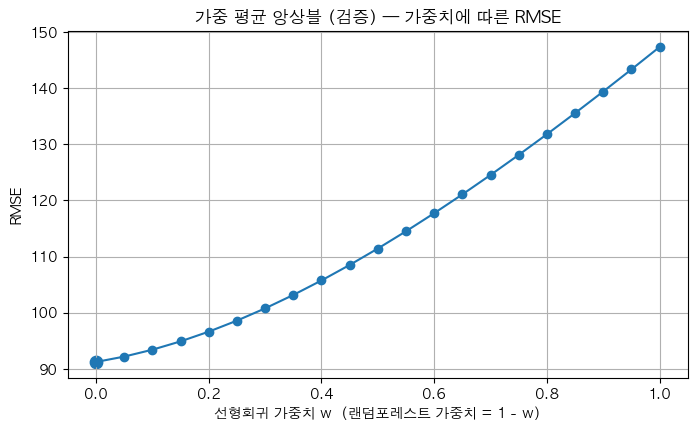


[검증 결과 상위 5개 (RMSE 기준)]
 w(linear)  w(rf)  linear%  rf%    MAE   RMSE    R2
     0.000  1.000        0  100 59.311 91.249 0.851
     0.050  0.950        5   95 60.226 92.205 0.848
     0.100  0.900       10   90 61.819 93.430 0.844
     0.150  0.850       15   85 63.734 94.912 0.839
     0.200  0.800       20   80 65.903 96.641 0.833
[Metrics]
MAE  : 68.762976 - 평균 절대 오차
MSE  : 10117.330518 - 평균 제곱 오차
RMSE : 100.584942 - 제곱근 평균 제곱 오차
R^2  : 0.731398 - 결정계수(설명된 분산 비율)

[요약]
- 최적 가중치 w = 0.00  (선형회귀 0%, 랜덤포레스트 100%)
- 검증 RMSE = 91.249
- 테스트 성능 → MAE=68.763, RMSE=100.585, R^2=0.731


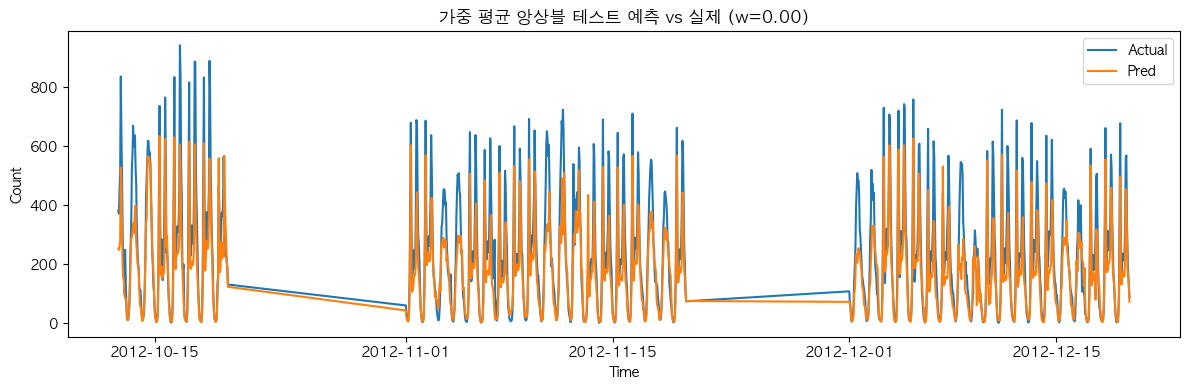

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def weighted_ensemble(y1, y2, w):
    return w*y1 + (1-w)*y2

# 가중치 탐색 + 결과 요약/시각화
def search_weight_and_report(lin_val_pred, rf_val_pred, y_val,
                             lin_test_pred, rf_test_pred, y_test,
                             weights=np.linspace(0, 1, 21),
                             title_prefix='앙상블'):
    rows = []
    best_w, best_rmse = None, float('inf')

    # 1) 검증에서 가중치별 성능 측정
    for w in weights:
        ens_val = weighted_ensemble(lin_val_pred, rf_val_pred, w)
        mae, mse, rmse, r2 = compute_metrics(y_val.to_numpy(), ens_val)
        rows.append({
            'weight_linear': float(w),
            'weight_rf': float(1-w),
            'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2
        })
        if rmse < best_rmse:
            best_rmse = rmse
            best_w = w

    # 2) 표로 정리
    df = pd.DataFrame(rows)
    df_sorted = df.sort_values('weight_linear').reset_index(drop=True)

    # 3) 가중치-성능 곡선 시각화 (RMSE 기준)
    plt.figure(figsize=(8,4.5))
    plt.plot(df_sorted['weight_linear'], df_sorted['RMSE'], marker='o')
    # 최적점 강조
    plt.scatter([best_w], [best_rmse], s=80)
    plt.title(f'{title_prefix} (검증) — 가중치에 따른 RMSE')
    plt.xlabel('선형회귀 가중치 w  (랜덤포레스트 가중치 = 1 - w)')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

    # 4) 상위 5개(낮은 RMSE) 출력
    topk = df.nsmallest(5, 'RMSE').copy()
    topk['linear%'] = (topk['weight_linear']*100).round(0).astype(int)
    topk['rf%'] = (topk['weight_rf']*100).round(0).astype(int)
    print('\n[검증 결과 상위 5개 (RMSE 기준)]')
    print(topk[['weight_linear', 'weight_rf', 'linear%', 'rf%', 'MAE', 'RMSE', 'R2']]
          .rename(columns={
              'weight_linear':'w(linear)',
              'weight_rf':'w(rf)'
          }).to_string(index=False, float_format=lambda x: f'{x:,.3f}'))

    # 5) 최적 가중치로 테스트 성능 평가
    ens_test = weighted_ensemble(lin_test_pred, rf_test_pred, best_w)
    mae_t, mse_t, rmse_t, r2_t = compute_metrics(y_test.to_numpy(), ens_test)

    print('\n[요약]')
    print(f"- 최적 가중치 w = {best_w:.2f}  "
          f"(선형회귀 {best_w*100:.0f}%, 랜덤포레스트 {(1-best_w)*100:.0f}%)")
    print(f"- 검증 RMSE = {best_rmse:.3f}")
    print(f"- 테스트 성능 → MAE={mae_t:.3f}, RMSE={rmse_t:.3f}, R^2={r2_t:.3f}")

    # 6) 테스트 구간 실제 vs 예측 그래프 (기존 함수 활용)
    try:
        plot_actual_vs_pred(
            test_df['datetime'].values,  # 기존에 쓰시던 test_df / x축
            y_test.to_numpy(),
            ens_test,
            f'{title_prefix} 테스트 예측 vs 실제 (w={best_w:.2f})'
        )
    except NameError:
        # 사용 환경에 따라 test_df가 없을 수 있으니 안전장치
        pass

    return best_w, df_sorted

# ---------------------------
# 사용 예시 (현재 변수 그대로 활용)
# ---------------------------
best_w, df_weights = search_weight_and_report(
    lin_val_pred, rf_val_pred, y_val,
    lin_test_pred, rf_test_pred, y_test,
    weights=np.linspace(0, 1, 21),  # 0.00 ~ 1.00, 0.05 간격이면  np.linspace(0,1,21)
    title_prefix='가중 평균 앙상블'
)


### 4. 성능 비교 요약
- MAE, MSE, RMSE, MAPE, 방향정확도(DA) 지표 비교
- 모델별 예측 vs 실제 시각화로 패턴 비교


### 4. 성능 평가 및 잔차 분석
- MAE/MSE/RMSE/MAPE, 방향정확도(DA)
- 예측 vs 실제 플롯, 잔차 시각화


## Residual Analysis  {#residual-analysis}

### 7. 잔차 분석
- 테스트 구간 잔차 시각화 및 분포 확인
- 패턴/이분산/비정상성 여부 점검


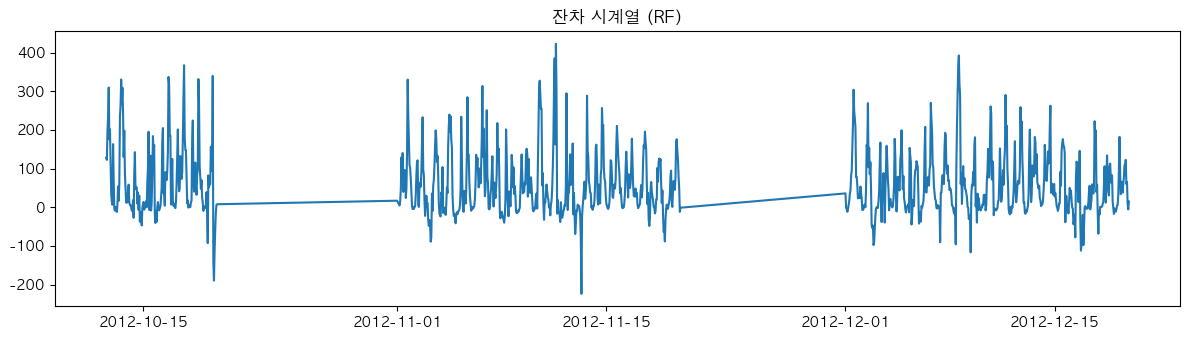

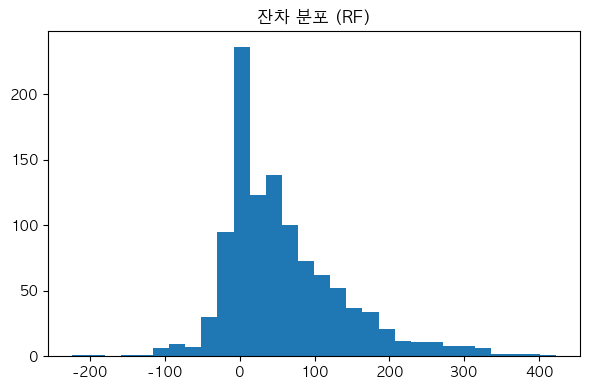

In [9]:
residual = y_test.to_numpy() - rf_test_pred
plt.figure(figsize=(12,3.5))
plt.plot(test_df['datetime'].values, residual)
plt.title('잔차 시계열 (RF)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(residual, bins=30)
plt.title('잔차 분포 (RF)')
plt.tight_layout(); plt.show()


## Miscellaneous

# Combined: Classical baselines + LSTM (cleaned)

- Source A: `Classical_baselines_reviewed.ipynb`
- Source B: `LSTM_reviewed.ipynb`
- Merged on: 2025-08-27 20:32:04

중복되는 코드/주석을 제거하고, 공통 유틸리티는 하나로 유지했습니다.

#### 강의 개요 및 학습 목표
- 시계열 예측의 중요성과 활용: 수요/재고/인력/교통/에너지 등
- 일반 회귀 vs 시계열 모델 차이: IID 가정 vs 자기상관/계절성/추세
- 실습을 통한 모델 성능 비교 학습 및 해석


### 5. 하이퍼파라미터 최적화 & 시계열 교차검증
- `TimeSeriesSplit`을 이용한 교차검증
- 랜덤포레스트 간단 Grid Search


In [6]:
def plot_timeseries_split(n_samples=30, n_splits=5):
    """
    TimeSeriesSplit이 어떻게 데이터를 나누는지 시각화
    
    Parameters
    ----------
    n_samples : int
        데이터 길이 (예: X_all.shape[0])
    n_splits : int
        TimeSeriesSplit의 분할 수
    """
    X = range(n_samples)
    tscv = TimeSeriesSplit(n_splits=n_splits)

    plt.figure(figsize=(12, 6))

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        # Train 부분 (파란색)
        plt.scatter(train_idx, [fold]*len(train_idx), 
                    marker='o', color='blue', s=40, 
                    label='Train' if fold == 1 else "")
        # Test 부분 (빨간색)
        plt.scatter(test_idx, [fold]*len(test_idx), 
                    marker='o', color='red', s=40, 
                    label='Test' if fold == 1 else "")

    plt.yticks(range(1, n_splits+1), [f"Fold {i}" for i in range(1, n_splits+1)])
    plt.xlabel("Index (시간 순서)")
    plt.ylabel("CV Fold")
    plt.title(f"TimeSeriesSplit 시각화 (샘플 {n_samples}, 분할 {n_splits})")
    plt.legend()
    plt.grid(True)
    plt.show()

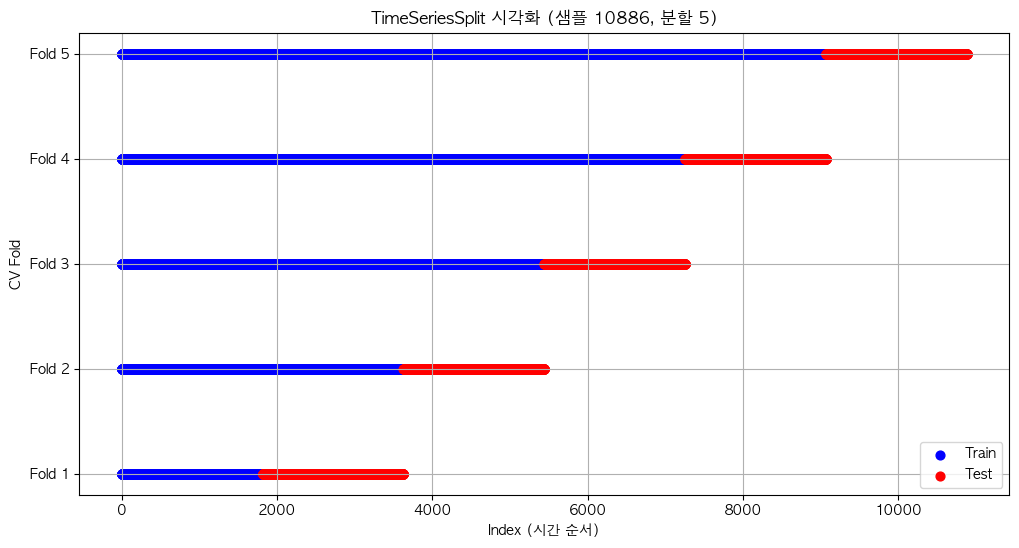

In [7]:
# 실제 데이터에 적용할 경우
plot_timeseries_split(n_samples=X_all_ts.shape[0], n_splits=5)

### 6. 앙상블 모델링 (가중 평균)
- 선형회귀와 랜덤포레스트의 검증 예측을 가중 평균
- 검증 성능으로 가중치 선택 후 테스트 평가


### 8. 강의 요약 및 다음 단계
- 모델별 지표 비교 및 해석 정리
- 시계열 특성(계절/추세/자기상관)을 반영한 모델 선택 가이드
- 다음 강의: LSTM/딥러닝 확장 및 하이브리드/앙상블 고도화


In [52]:
import sys, importlib
import numpy as np, pandas as pd
print('py:', sys.executable)
print('numpy:', np.__version__, 'pandas:', pd.__version__)
print('numpy.rec spec:', importlib.util.find_spec('numpy.rec'))
print('numpy.core.records spec:', importlib.util.find_spec('numpy.core.records'))

py: /Users/kimjinseok/Desktop/metacode-lecture/.venv/bin/python
numpy: 1.26.4 pandas: 2.3.2
numpy.rec spec: None
numpy.core.records spec: ModuleSpec(name='numpy.core.records', loader=<_frozen_importlib_external.SourceFileLoader object at 0x11046ebd0>, origin='/Users/kimjinseok/Desktop/metacode-lecture/.venv/lib/python3.12/site-packages/numpy/core/records.py')


In [53]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess

# 전역 경고 억제 (미래/폐기 예정 경고 및 폰트 경고 노이즈 제거)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=r"Glyph.*missing from font.*", category=UserWarning)

# 한글 폰트 설정 및 마이너스 기호 깨짐 방지 (후보군을 sans-serif 우선순위로 지정)
def _set_korean_font() -> None:
    font_candidates = [
        "AppleGothic",
        "NanumGothic",
        "Malgun Gothic",
        "Noto Sans CJK KR",
        "Noto Sans KR",
        "DejaVu Sans",
    ]
    # 우선순위 리스트를 그대로 등록하여 사용 가능한 항목으로 대체되도록 함
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = font_candidates
    plt.rcParams["axes.unicode_minus"] = False

_set_korean_font()

# 노트북 전체 표시 옵션
pd.set_option('display.max_columns', 50)

## Chapter 2-3, 2-2강 시계열 예측 모델링 — PyTorch LSTM (Bike Sharing)

- **목표**: 시계열을 시퀀스 형태로 변환하고 LSTM으로 예측 학습/평가합니다.
- **데이터**: Kaggle Bike Sharing Demand (시간 단위, `count` 대상)
- **규칙(강의용)**: `matplotlib`만 사용 (seaborn X), 색상 지정 X, 서브플롯 X


### 0. 환경 준비 및 라이브러리 임포트
- PyTorch LSTM 구현 (GPU 없어도 CPU에서 동작)
- 재현성을 위한 시드 고정


In [54]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def _set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



### 2. 시퀀스 데이터셋 생성 및 LSTM 모델 정의
- 윈도우 크기 24(하루)로 시퀀스 구성, horizon=1
- 단순 LSTM 회귀 헤드


### 5. 강의 요약 및 다음 단계
- 윈도우 기반 시퀀스 모델의 장단점
- 베이스라인 대비 개선 포인트 및 추가 실험 아이디어(스택드 LSTM, Dropout, 다중 스텝 예측)
